In [53]:
# Step 4: Load cleaned data and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load your outlier-handled dataset
df = pd.read_csv('no_outliers_test.csv')
print("Loaded cleaned dataset shape:", df.shape)

# Separate features and target
target_col = 'satisfaction_encoded'
X = df.drop(target_col, axis=1)
y = df[target_col]

print(f"Features shape: {X.shape}, Target shape: {y.shape}")

# Identify key feature groups
service_rating_cols = [col for col in X.columns if any(keyword in col.lower() 
                   for keyword in ['service', 'comfort', 'cleanliness', 'food', 'entertainment'])]
delay_cols = [col for col in X.columns if 'delay' in col.lower()]
travel_cols = [col for col in X.columns if any(keyword in col.lower() 
              for keyword in ['age', 'flight distance', 'class'])]

print(f"\nFeature Groups:")
print(f"   Service Ratings: {len(service_rating_cols)} columns")
print(f"    Delay Columns: {len(delay_cols)} columns") 
print(f"   Travel Info: {len(travel_cols)} columns")

Loaded cleaned dataset shape: (18875, 26)
Features shape: (18875, 25), Target shape: (18875,)

Feature Groups:
   Service Ratings: 9 columns
    Delay Columns: 2 columns
   Travel Info: 5 columns


In [41]:
#SERVICE QUALITY FEATURES

print("CREATING SERVICE QUALITY FEATURES")
print("-"*60)

X_engineered = X.copy()

# 1. Total Service Score (average of all service ratings)
if len(service_rating_cols) > 0:
    X_engineered['Total_Service_Score'] = X[service_rating_cols].mean(axis=1)
    print(f"Created 'Total_Service_Score' (avg of {len(service_rating_cols)} ratings)")

# 2. Comfort Score (seat, legroom, cleanliness)
comfort_cols = [col for col in service_rating_cols if any(word in col.lower() 
             for word in ['seat', 'leg room', 'cleanliness'])]
if len(comfort_cols) >= 2:
    X_engineered['Comfort_Score'] = X[comfort_cols].mean(axis=1)
    print(f"Created 'Comfort_Score' (avg of {len(comfort_cols)} comfort ratings)")

# 3. Digital Experience (wifi, online booking, boarding)
digital_cols = [col for col in service_rating_cols if any(word in col.lower() 
             for word in ['wifi', 'online booking', 'online boarding'])]
if len(digital_cols) >= 2:
    X_engineered['Digital_Experience'] = X[digital_cols].mean(axis=1)
    print(f"Created 'Digital_Experience' (avg of {len(digital_cols)} digital ratings)")

print(f"Service features created: {len(['Total_Service_Score', 'Comfort_Score', 'Digital_Experience']) if 'Total_Service_Score' in X_engineered.columns else 0}")

CREATING SERVICE QUALITY FEATURES
------------------------------------------------------------
Created 'Total_Service_Score' (avg of 9 ratings)
Created 'Comfort_Score' (avg of 3 comfort ratings)
Service features created: 3


In [43]:
# DELAY IMPACT FEATURES

print("CREATING DELAY IMPACT FEATURES")
print("-"*60)

# 1. Total Delay (departure + arrival)
if all(col in X_engineered.columns for col in delay_cols):
    X_engineered['Total_Delay_Minutes'] = X_engineered[delay_cols].sum(axis=1)
    print("Created 'Total_Delay_Minutes' (departure + arrival)")

# 2. Significant Delay Flag (>30 minutes)
if 'Total_Delay_Minutes' in X_engineered.columns:
    X_engineered['Significant_Delay_Flag'] = (X_engineered['Total_Delay_Minutes'] > 30).astype(int)
    print("Created 'Significant_Delay_Flag' (>30 minutes)")

# 3. Delay Ratio (arrival/departure)
if all(col in X_engineered.columns for col in delay_cols):
    X_engineered['Delay_Ratio'] = X_engineered['remainder__Arrival Delay in Minutes'] / (X_engineered['remainder__Departure Delay in Minutes'] + 1)
    print("Created 'Delay_Ratio' (arrival/departure)")

print(f"Delay features created: {len(['Total_Delay_Minutes', 'Significant_Delay_Flag', 'Delay_Ratio'])}")

CREATING DELAY IMPACT FEATURES
------------------------------------------------------------
Created 'Total_Delay_Minutes' (departure + arrival)
Created 'Significant_Delay_Flag' (>30 minutes)
Created 'Delay_Ratio' (arrival/departure)
Delay features created: 3


In [45]:
print("CREATING TRAVEL EXPERIENCE FEATURES")
print("-"*60)

#Long Haul Flag (>2000 miles)
if 'remainder__Flight Distance' in X_engineered.columns:
    X_engineered['Long_Haul_Flight'] = (X_engineered['remainder__Flight Distance'] > 2000).astype(int)
    print("Created 'Long_Haul_Flight' (>2000 miles)")

#Estimated Flight Hours
if 'remainder__Flight Distance' in X_engineered.columns:
    X_engineered['Estimated_Flight_Hours'] = X_engineered['remainder__Flight Distance'] / 500
    print("Created 'Estimated_Flight_Hours' (distance/500mph)")

#Business Travel Premium
business_class_cols = [col for col in X_engineered.columns if 'class_eco' in col.lower()]
if business_class_cols:

    eco_class = X_engineered[business_class_cols[0]].fillna(0)
    business_class = 1 - eco_class  # Convert eco=1 to business=1, eco=0
    X_engineered['Business_Travel_Premium'] = business_class
    print("Created 'Business_Travel_Premium' (business class indicator)")

print(f"Travel features created: {len(['Long_Haul_Flight', 'Estimated_Flight_Hours', 'Business_Travel_Premium'])}")

CREATING TRAVEL EXPERIENCE FEATURES
------------------------------------------------------------
Created 'Long_Haul_Flight' (>2000 miles)
Created 'Estimated_Flight_Hours' (distance/500mph)
Created 'Business_Travel_Premium' (business class indicator)
Travel features created: 3


In [47]:
print("CREATING CUSTOMER PROFILE FEATURES")
print("-"*60)

#Age Groups
if 'remainder__Age' in X_engineered.columns:
    X_engineered['Age_Group'] = pd.cut(X_engineered['remainder__Age'], 
                                      bins=[0, 25, 35, 50, 65, 120], 
                                      labels=[0, 1, 2, 3, 4])
    X_engineered['Age_Group'] = X_engineered['Age_Group'].astype(int)
    print("Created 'Age_Group' (0=Young, 4=Senior)")

#Experience Expectation (age × service)
if 'Total_Service_Score' in X_engineered.columns and 'remainder__Age' in X_engineered.columns:
    X_engineered['Experience_Expectation'] = X_engineered['remainder__Age'] * X_engineered['Total_Service_Score']
    print("Created 'Experience_Expectation' (age × service score)")

print(f"Profile features created: {len(['Age_Group', 'Experience_Expectation'])}")

CREATING CUSTOMER PROFILE FEATURES
------------------------------------------------------------
Created 'Age_Group' (0=Young, 4=Senior)
Created 'Experience_Expectation' (age × service score)
Profile features created: 2


In [49]:
# MATHEMATICAL FEATURES

print("CREATING MATHEMATICAL FEATURES")
print("-"*60)

# 1. Service-to-Delay Ratio
if 'Total_Service_Score' in X_engineered.columns and 'Total_Delay_Minutes' in X_engineered.columns:
    X_engineered['Service_to_Delay_Ratio'] = X_engineered['Total_Service_Score'] / (X_engineered['Total_Delay_Minutes']/60 + 1)
    print("Created 'Service_to_Delay_Ratio' (service vs delay)")

# 2. Comfort per Mile
if 'Comfort_Score' in X_engineered.columns and 'remainder__Flight Distance' in X_engineered.columns:
    X_engineered['Comfort_Per_Mile'] = X_engineered['Comfort_Score'] / (X_engineered['remainder__Flight Distance']/1000 + 0.1)
    print("Created 'Comfort_Per_Mile' (comfort per 1000 miles)")

# 3. Delay Impact Score
if 'Delay_Ratio' in X_engineered.columns and 'Total_Service_Score' in X_engineered.columns:
    X_engineered['Delay_Impact_Score'] = X_engineered['Delay_Ratio'] * (5 - X_engineered['Total_Service_Score'])
    print("Created 'Delay_Impact_Score' (delay × low service)")

print(f"Math features created: {len(['Service_to_Delay_Ratio', 'Comfort_Per_Mile', 'Delay_Impact_Score'])}")

CREATING MATHEMATICAL FEATURES
------------------------------------------------------------
Created 'Service_to_Delay_Ratio' (service vs delay)
Created 'Comfort_Per_Mile' (comfort per 1000 miles)
Created 'Delay_Impact_Score' (delay × low service)
Math features created: 3


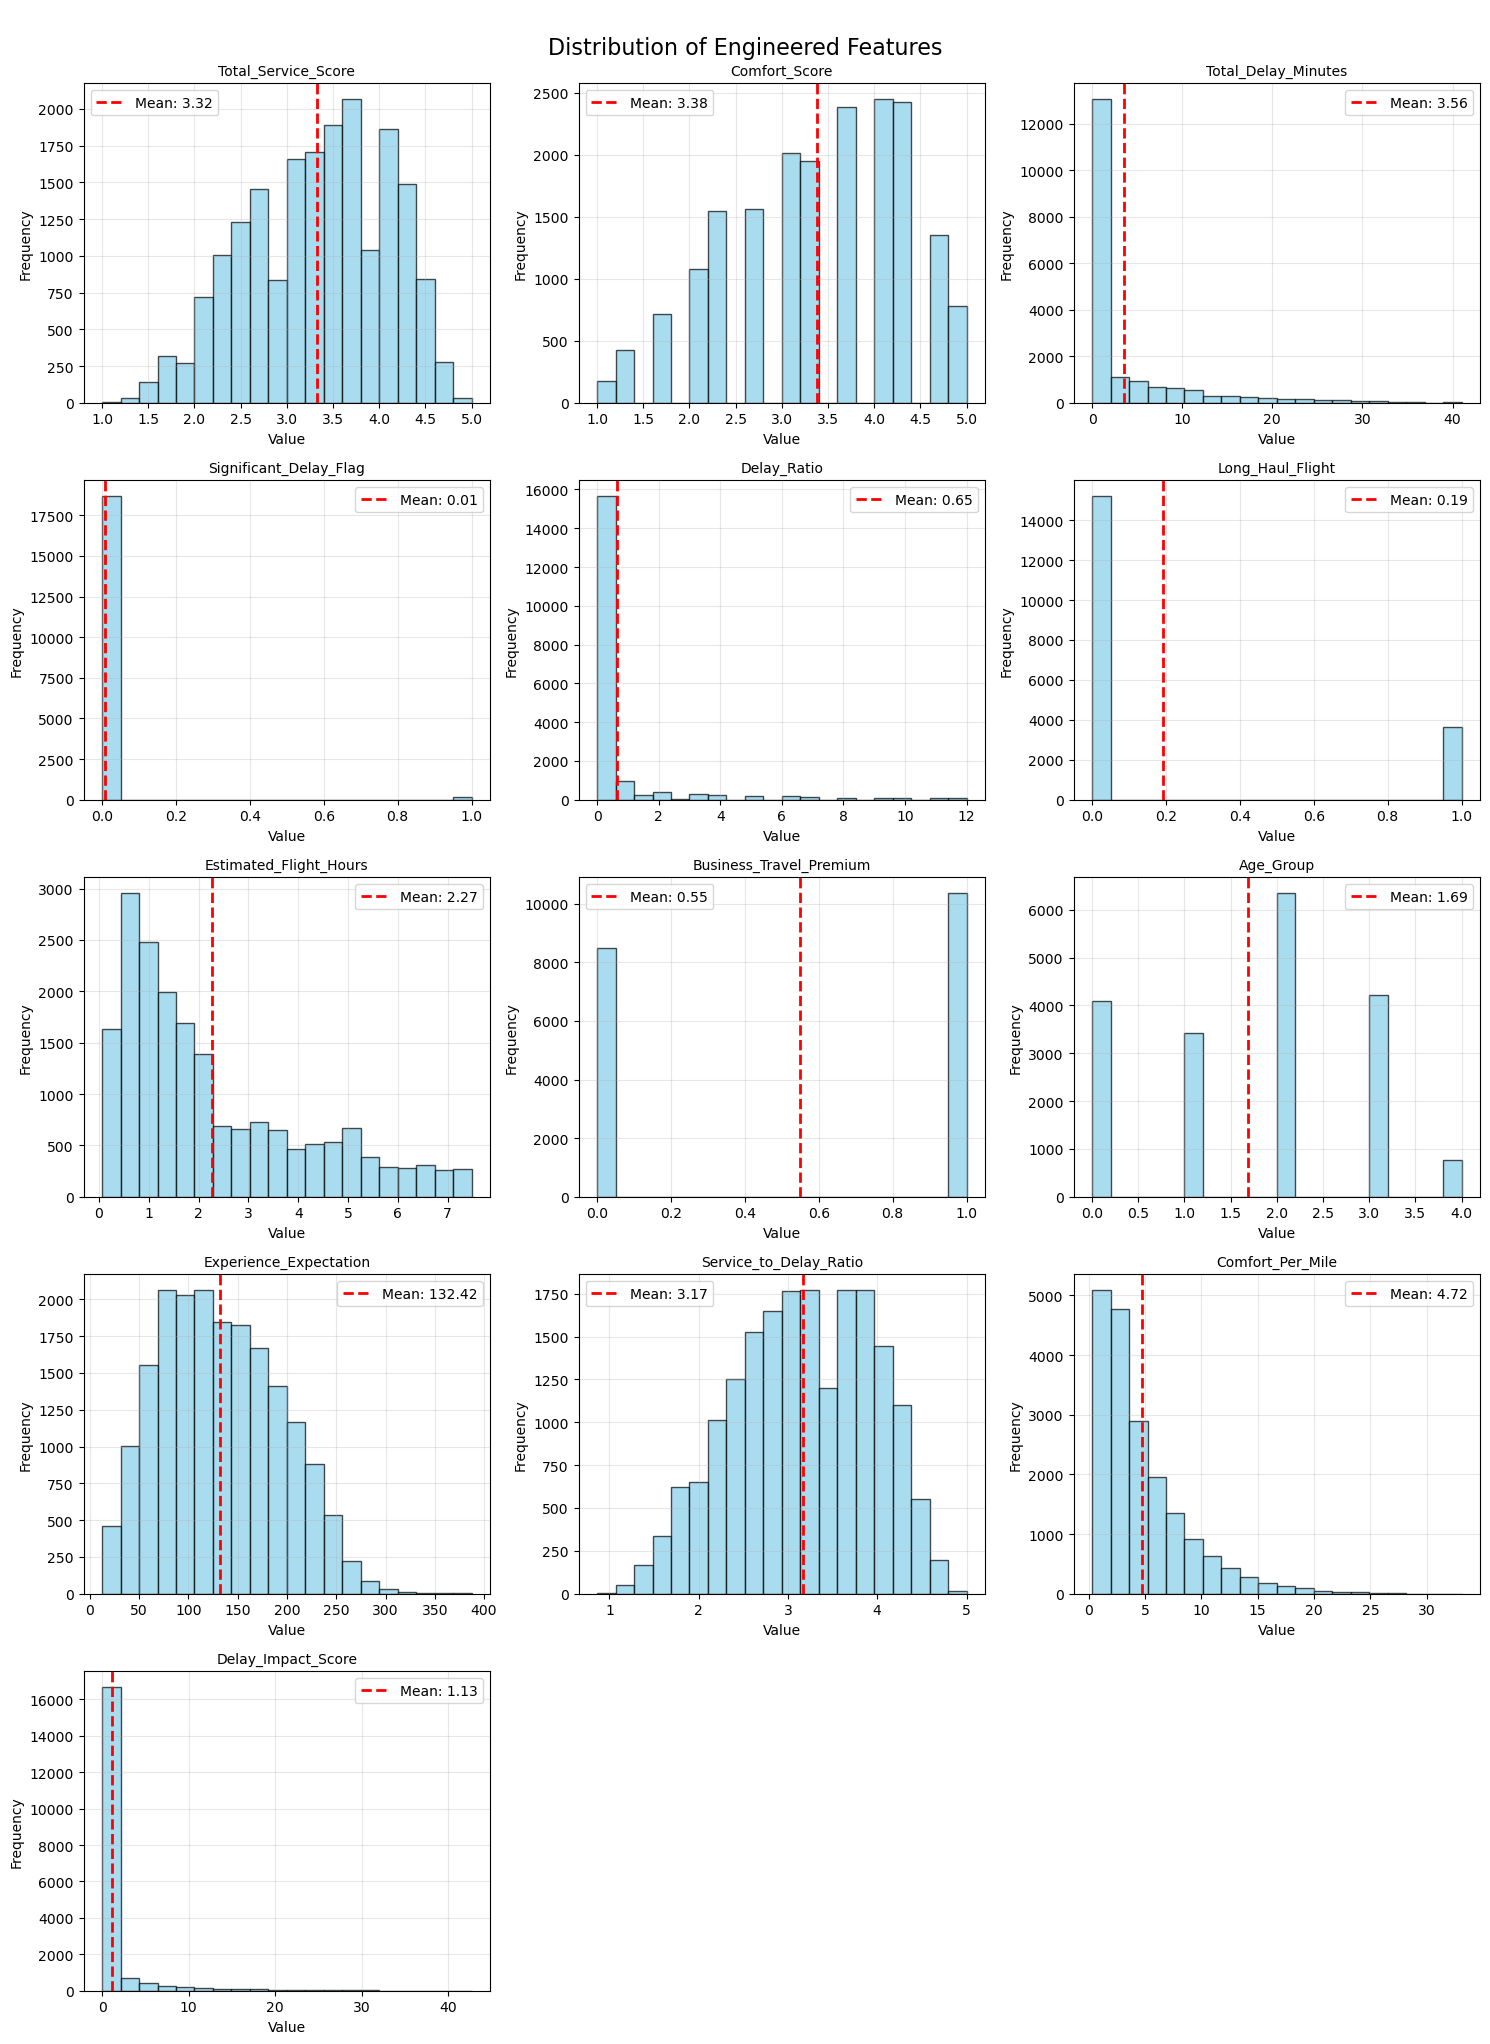

In [55]:
# Calculate number of rows and columns
n_features = len(new_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.ravel()

# histogram for each feature
for i, feature in enumerate(new_features):
    ax = axes[i]
    
    ax.hist(X_engineered[feature].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(feature, fontsize=10)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Add mean line
    mean_val = X_engineered[feature].mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.legend()

# Hide empty subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)
    
plt.tight_layout()
plt.suptitle('\nDistribution of Engineered Features', fontsize=16, y=1.02)
plt.show()

In [57]:
# Count new features
original_cols = X.shape[1]
new_features = len([col for col in X_engineered.columns if col not in X.columns])
total_features = X_engineered.shape[1]

print(f" FEATURE ENGINEERING COMPLETE:")
print(f"  Original: {original_cols} features")
print(f"   Created: {new_features} new features")
print(f"   Total: {total_features} features")
print(f"  Increase: {((total_features/original_cols-1)*100):+.1f}%")

new_features_list = [col for col in X_engineered.columns if col not in X.columns]
print(f"\n NEW FEATURES CREATED ({len(new_features_list)}):")
for i, feature in enumerate(new_features_list, 1):
    print(f"  {i:2d}. {feature}")

print(f"\n QUICK VALIDATION:")
print(f"   No missing values: {X_engineered.isnull().sum().sum() == 0}")
print(f"   All numeric: {len(X_engineered.select_dtypes(include=['object']).columns) == 0}")

df_engineered = pd.concat([X_engineered, y], axis=1)
output_file = 'feature_engineering.csv'
df_engineered.to_csv(output_file, index=False)

 FEATURE ENGINEERING COMPLETE:
  Original: 25 features
   Created: 13 new features
   Total: 38 features
  Increase: +52.0%

 NEW FEATURES CREATED (13):
   1. Total_Service_Score
   2. Comfort_Score
   3. Total_Delay_Minutes
   4. Significant_Delay_Flag
   5. Delay_Ratio
   6. Long_Haul_Flight
   7. Estimated_Flight_Hours
   8. Business_Travel_Premium
   9. Age_Group
  10. Experience_Expectation
  11. Service_to_Delay_Ratio
  12. Comfort_Per_Mile
  13. Delay_Impact_Score

 QUICK VALIDATION:
   No missing values: True
   All numeric: True
